### IMPORT

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv


In [37]:
# Modellerin import edilmesi
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### VERİ YÜKLEME

In [4]:
df = pd.read_csv("/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv")

In [82]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


### KEŞİFÇİ VERİ ANALİZİ

In [6]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    #print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [7]:
check_df(df)

##################### Shape #####################
(100000, 18)
##################### Types #####################
obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object
##################### Head #####################
         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301      

In [5]:
def grab_col_names(dataframe, cat_th=15, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, cat_but_car, num_cols

In [6]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 100000
Variables: 18
cat_cols: 3
num_cols: 15
cat_but_car: 0
num_but_cat: 2


In [13]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

In [22]:
for col in cat_cols: 
        cat_summary(df, col)
   

        class   Ratio
class                
GALAXY  59445  59.445
STAR    21594  21.594
QSO     18961  18.961
          rerun_ID  Ratio
rerun_ID                 
301         100000  100.0
         cam_col   Ratio
cam_col                 
4          19573  19.573
3          18851  18.851
5          18537  18.537
2          17117  17.117
1          13227  13.227
6          12695  12.695


Burada verinin nispeten dengeli dağılmış olması, teleskobun gökyüzünü tararken tüm sensörlerini aktif ve verimli kullandığını kanıtlar.

/tmp/ipykernel_55/3252793253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


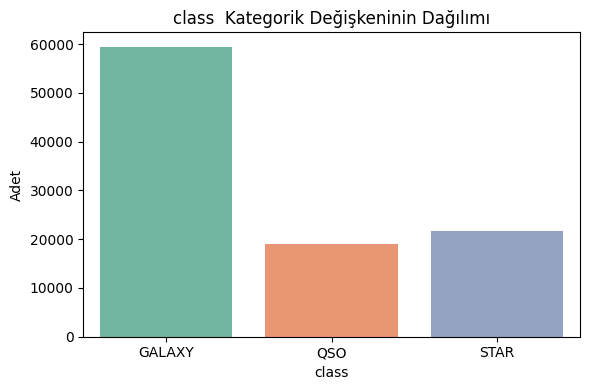

/tmp/ipykernel_55/3252793253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


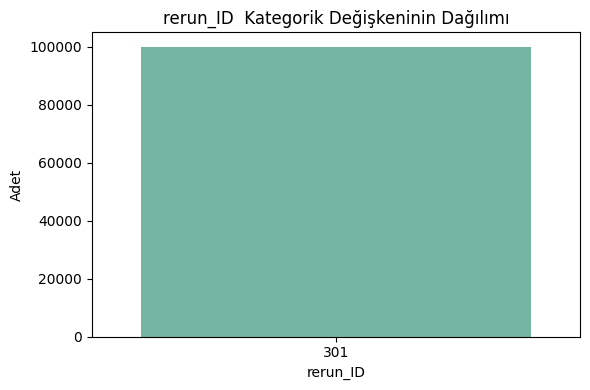

/tmp/ipykernel_55/3252793253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


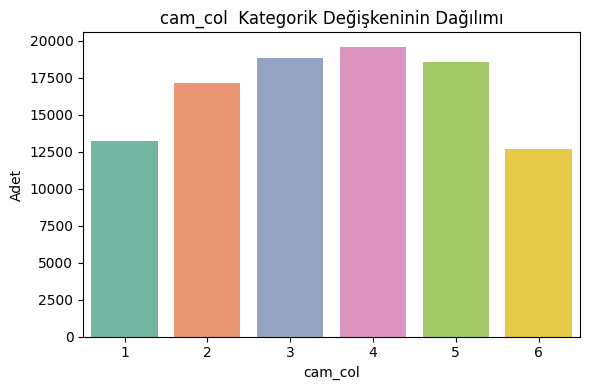

In [29]:
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, palette="Set2")
    plt.title(f"{col}  Kategorik Değişkeninin Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Adet")
    plt.tight_layout()
    plt.show()

count    1.000000e+05
mean     1.237665e+18
std      8.438560e+12
min      1.237646e+18
5%       1.237652e+18
10%      1.237654e+18
20%      1.237658e+18
30%      1.237661e+18
40%      1.237662e+18
50%      1.237663e+18
60%      1.237665e+18
70%      1.237668e+18
80%      1.237671e+18
90%      1.237679e+18
95%      1.237680e+18
99%      1.237680e+18
max      1.237681e+18
Name: obj_ID, dtype: float64


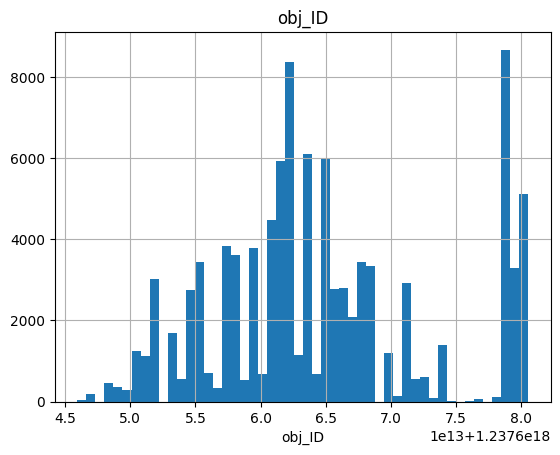

#####################################
count    100000.000000
mean        177.629117
std          96.502241
min           0.005528
5%           11.750808
10%          23.783165
20%         116.399219
30%         135.654002
40%         156.016785
50%         180.900700
60%         203.201928
70%         224.105956
80%         243.562323
90%         331.912643
95%         348.769819
99%         357.980799
max         359.999810
Name: alpha, dtype: float64


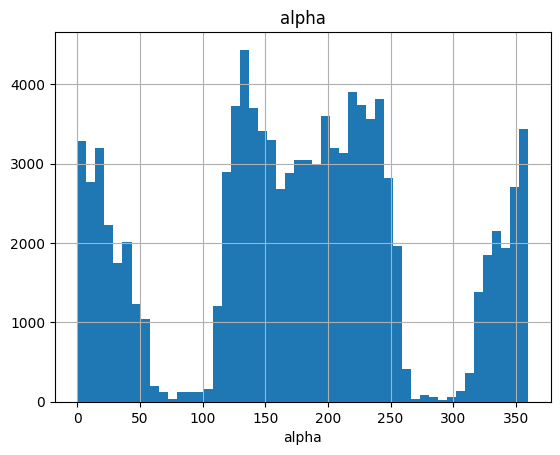

#####################################
count    100000.000000
mean         24.135305
std          19.644665
min         -18.785328
5%           -2.365670
10%          -0.659503
20%           2.279783
30%           9.515676
40%          17.374757
50%          23.645922
60%          30.345255
70%          36.504370
80%          43.167853
90%          51.013175
95%          56.701075
99%          65.142702
max          83.000519
Name: delta, dtype: float64


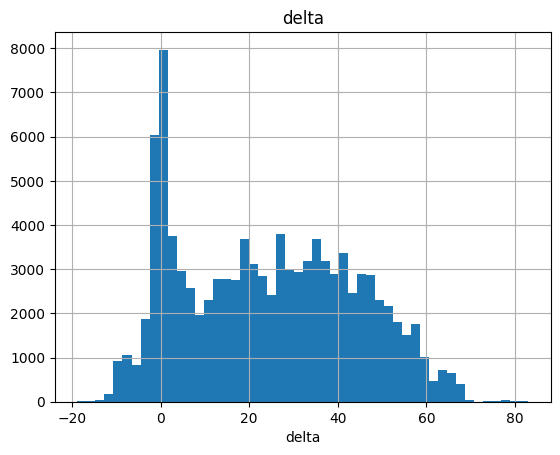

#####################################
count    100000.000000
mean         21.980468
std          31.769291
min       -9999.000000
5%           18.430930
10%          19.117051
20%          19.961014
30%          20.748600
40%          21.560668
50%          22.179135
60%          22.741812
70%          23.334252
80%          24.083744
90%          25.096416
95%          25.785050
99%          26.657341
max          32.781390
Name: u, dtype: float64


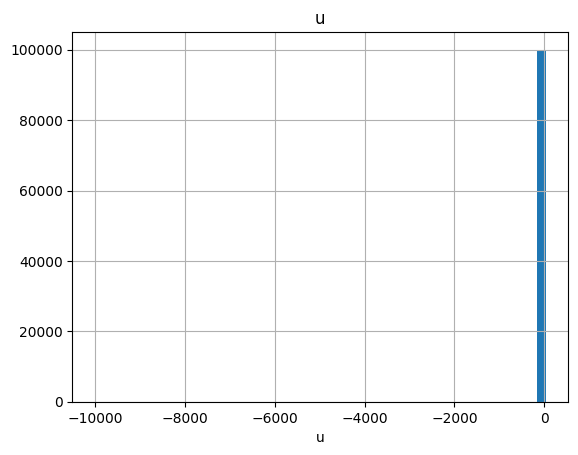

#####################################
count    100000.000000
mean         20.531387
std          31.750292
min       -9999.000000
5%           17.072820
10%          17.757718
20%          18.528204
30%          19.532486
40%          20.483238
50%          21.099835
60%          21.551900
70%          21.936786
80%          22.337636
90%          22.891737
95%          23.408262
99%          24.637623
max          31.602240
Name: g, dtype: float64


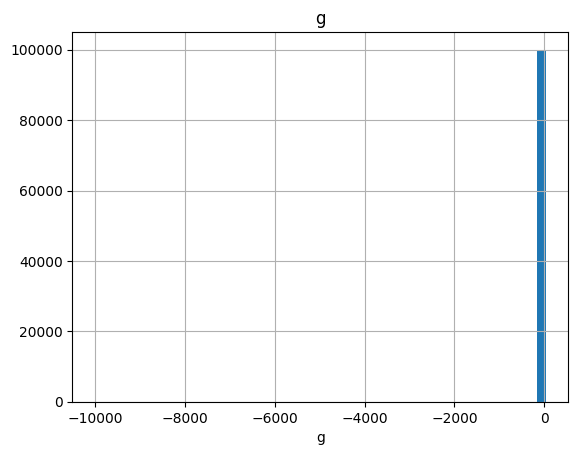

#####################################
count    100000.000000
mean         19.645762
std           1.854760
min           9.822070
5%           16.393046
10%          17.009738
20%          17.697234
30%          18.689505
40%          19.486618
50%          20.125290
60%          20.502848
70%          20.848339
80%          21.270734
90%          21.763206
95%          22.070249
99%          22.794967
max          29.571860
Name: r, dtype: float64


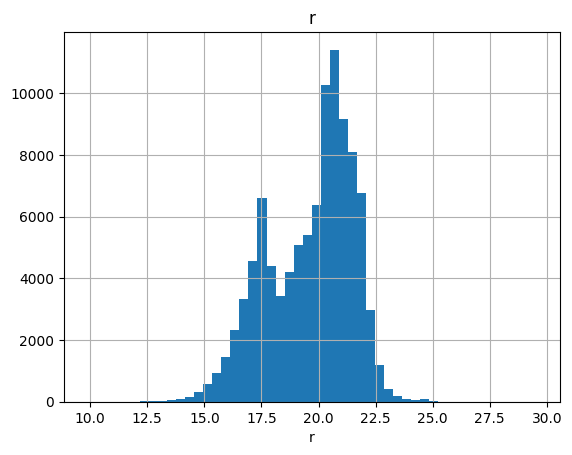

#####################################
count    100000.000000
mean         19.084854
std           1.757895
min           9.469903
5%           16.043819
10%          16.619008
20%          17.298682
30%          18.224892
40%          18.906586
50%          19.405145
60%          19.736628
70%          20.127593
80%          20.643606
90%          21.236341
95%          21.607623
99%          22.158517
max          32.141470
Name: i, dtype: float64


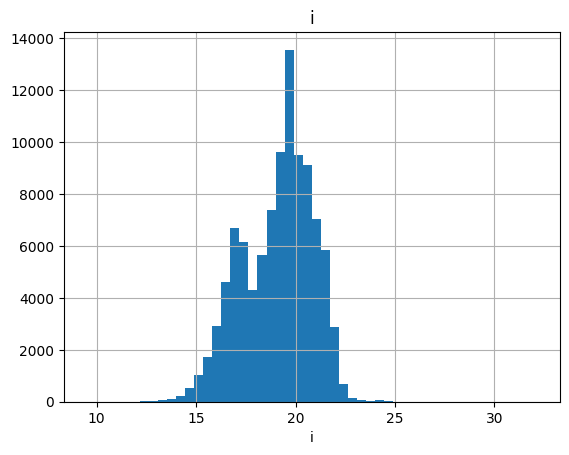

#####################################
count    100000.000000
mean         18.668810
std          31.728152
min       -9999.000000
5%           15.778155
10%          16.341922
20%          17.032588
30%          17.906282
40%          18.552554
50%          19.004595
60%          19.339320
70%          19.713277
80%          20.254234
90%          21.007802
95%          21.462771
99%          22.365484
max          29.383740
Name: z, dtype: float64


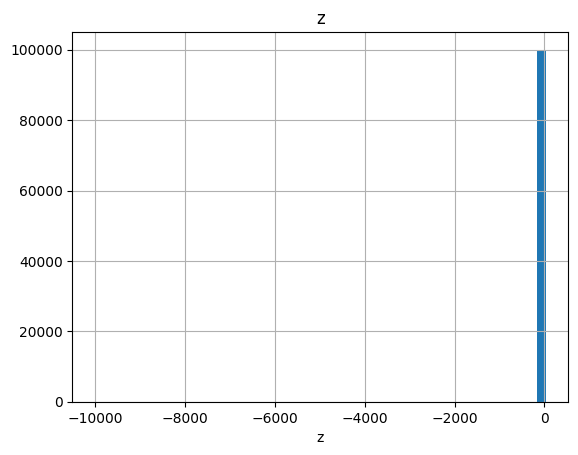

#####################################
count    100000.000000
mean       4481.366060
std        1964.764593
min         109.000000
5%         1412.000000
10%        2076.000000
20%        2831.000000
30%        3562.000000
40%        3840.000000
50%        4188.000000
60%        4576.000000
70%        5137.000000
80%        6004.000000
90%        7773.000000
95%        8038.000000
99%        8116.000000
max        8162.000000
Name: run_ID, dtype: float64


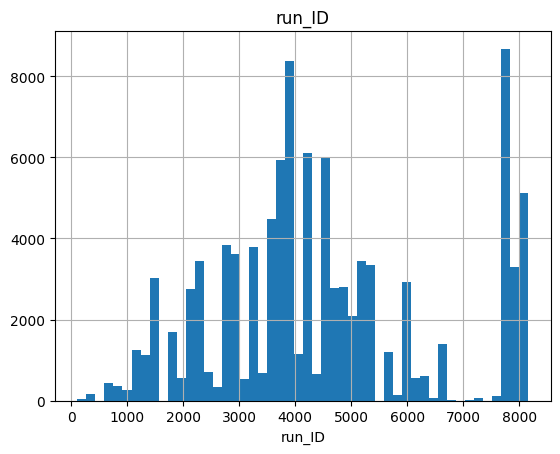

#####################################
count    100000.000000
mean        186.130520
std         149.011073
min          11.000000
5%           31.000000
10%          46.000000
20%          70.000000
30%          94.000000
40%         119.000000
50%         146.000000
60%         178.000000
70%         215.000000
80%         272.000000
90%         376.000000
95%         489.000000
99%         774.010000
max         989.000000
Name: field_ID, dtype: float64


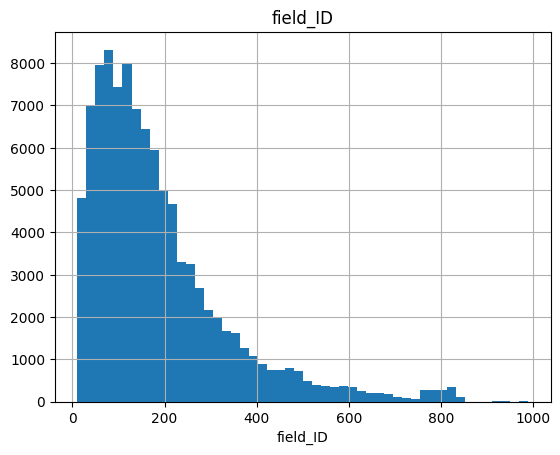

#####################################
count    1.000000e+05
mean     5.783882e+18
std      3.324016e+18
min      2.995191e+17
5%       8.186592e+17
10%      1.320828e+18
20%      2.336388e+18
30%      3.557915e+18
40%      4.739135e+18
50%      5.614883e+18
60%      6.799378e+18
70%      7.806119e+18
80%      8.824863e+18
90%      1.037534e+19
95%      1.174436e+19
99%      1.273962e+19
max      1.412694e+19
Name: spec_obj_ID, dtype: float64


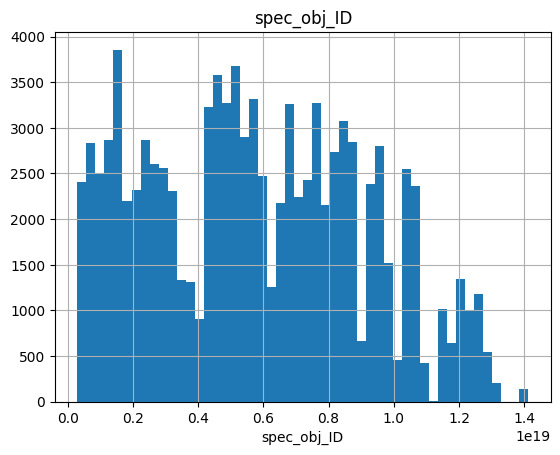

#####################################
count    100000.000000
mean          0.576661
std           0.730707
min          -0.009971
5%           -0.000326
10%          -0.000101
20%           0.000273
30%           0.097152
40%           0.228664
50%           0.424173
60%           0.526129
70%           0.621392
80%           0.823949
90%           1.563901
95%           2.187728
99%           3.127080
max           7.011245
Name: redshift, dtype: float64


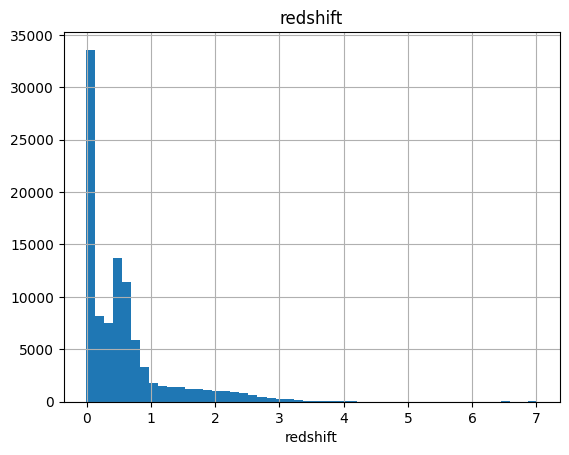

#####################################
count    100000.000000
mean       5137.009660
std        2952.303351
min         266.000000
5%          727.000000
10%        1173.000000
20%        2075.000000
30%        3160.000000
40%        4209.000000
50%        4987.000000
60%        6039.000000
70%        6933.000000
80%        7838.000000
90%        9215.000000
95%       10431.000000
99%       11315.000000
max       12547.000000
Name: plate, dtype: float64


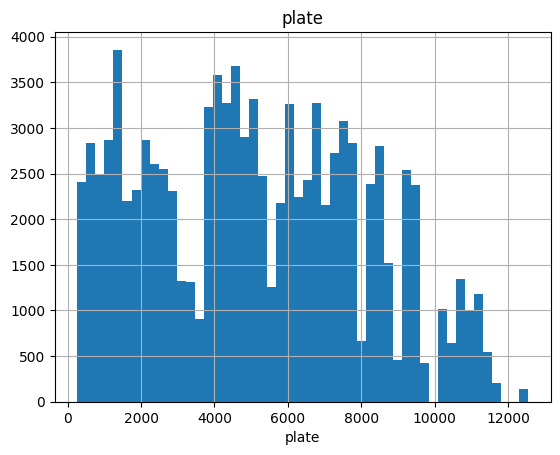

#####################################
count    100000.000000
mean      55588.647500
std        1808.484233
min       51608.000000
5%        52337.450000
10%       52751.000000
20%       53739.000000
30%       54825.000000
40%       55539.000000
50%       55868.500000
60%       56214.000000
70%       56570.000000
80%       57312.000000
90%       58043.000000
95%       58200.000000
99%       58485.000000
max       58932.000000
Name: MJD, dtype: float64


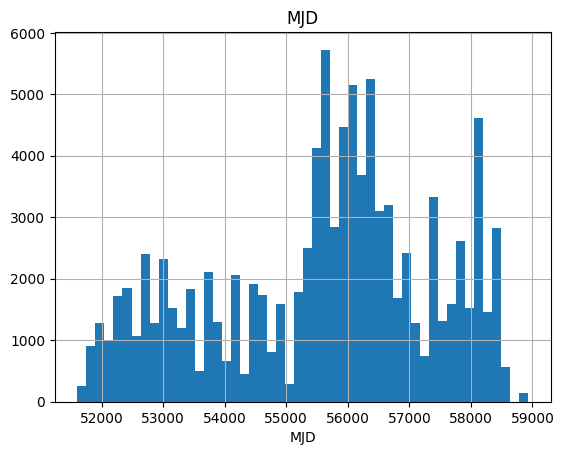

#####################################
count    100000.000000
mean        449.312740
std         272.498404
min           1.000000
5%           46.000000
10%          90.000000
20%         177.000000
30%         264.000000
40%         348.000000
50%         433.000000
60%         519.000000
70%         602.000000
80%         715.000000
90%         854.000000
95%         926.000000
99%         986.000000
max        1000.000000
Name: fiber_ID, dtype: float64


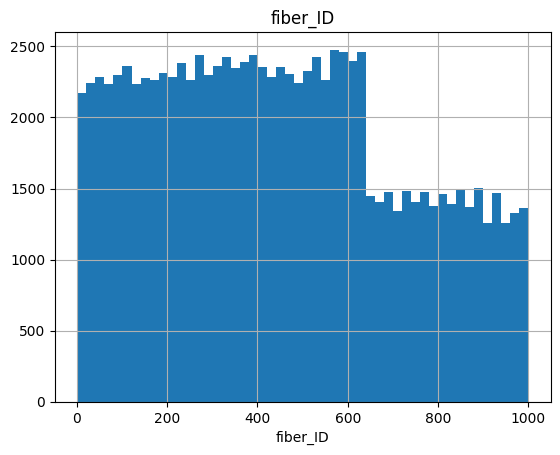

#####################################


In [30]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df, col, True)

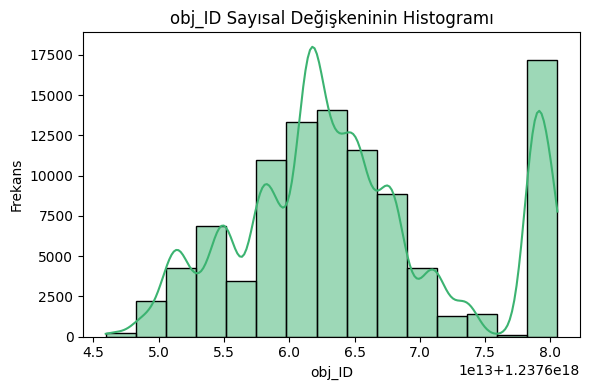

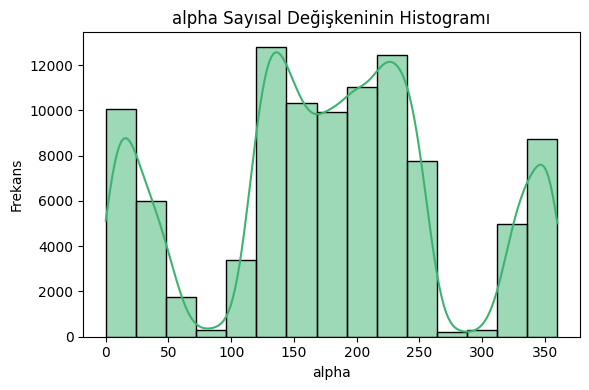

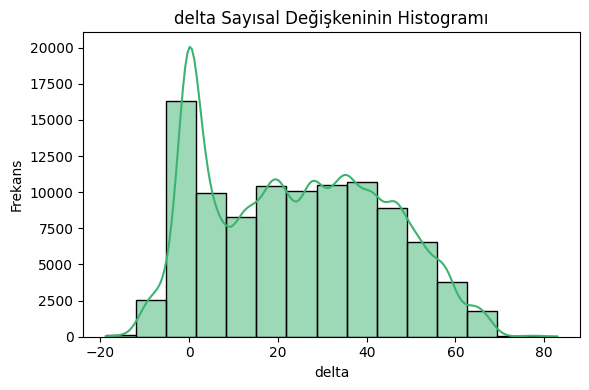

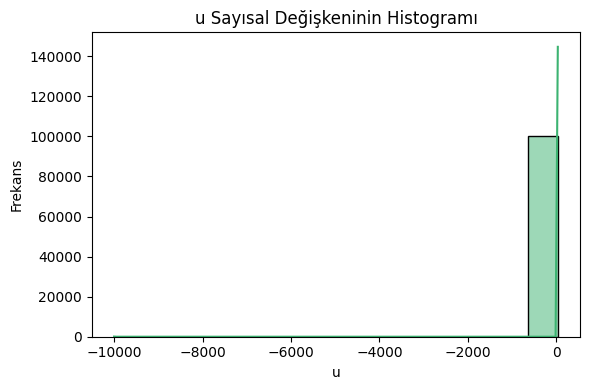

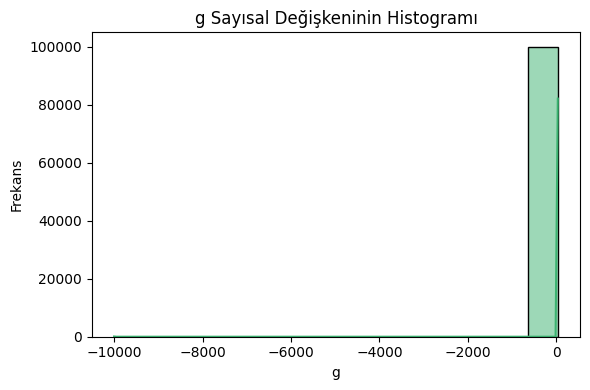

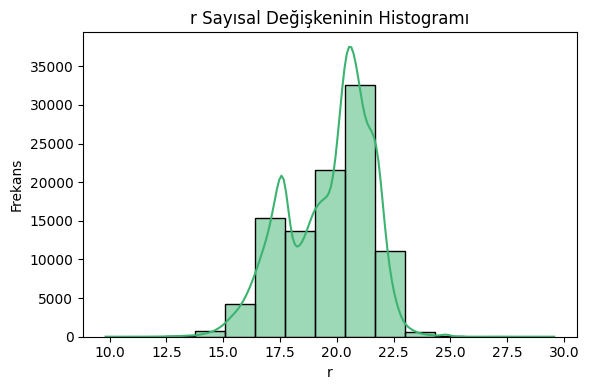

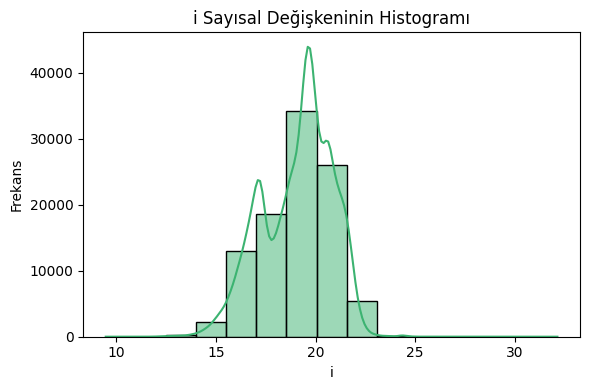

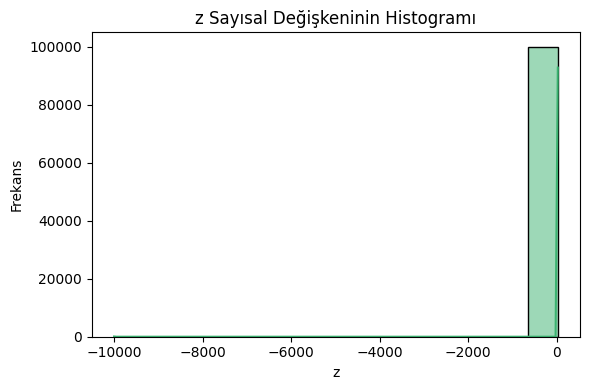

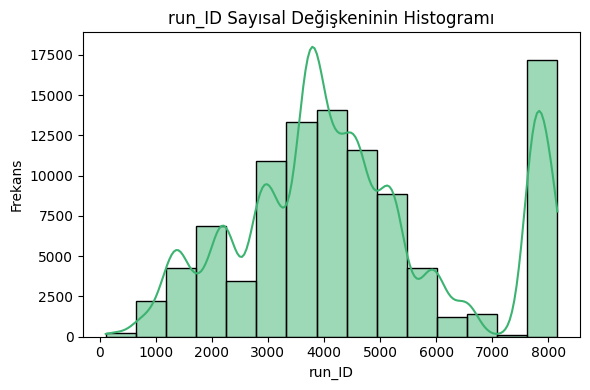

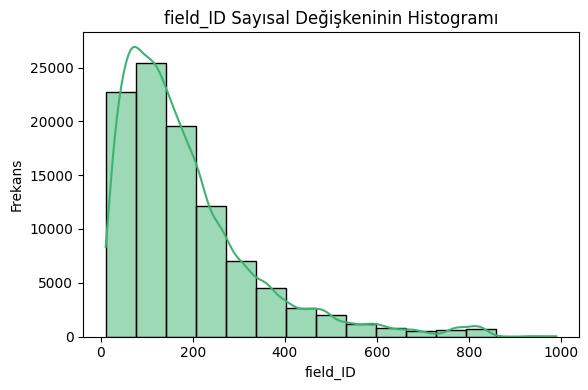

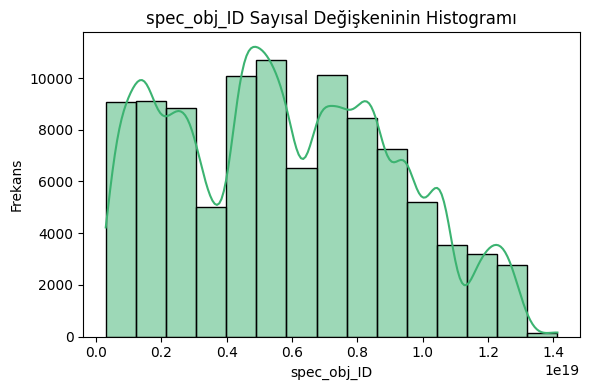

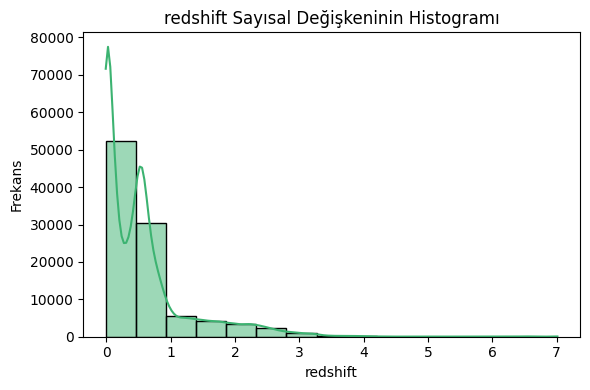

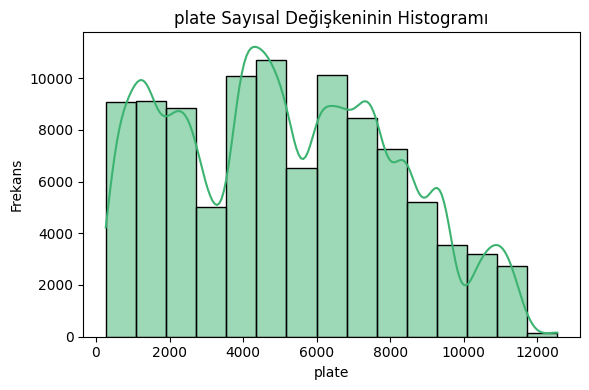

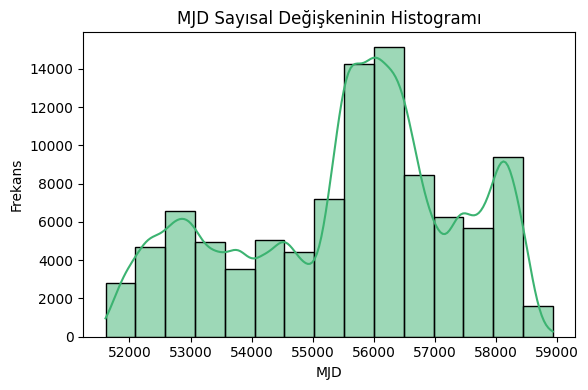

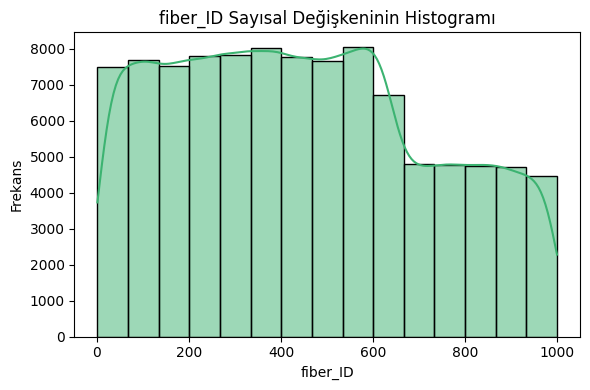

In [31]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=15, kde=True, color="mediumseagreen")
    plt.title(f"{col} Sayısal Değişkeninin Histogramı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.tight_layout()
    plt.show()

mesela korelasyon analizinde "MJD" ve "plate" arasında güçlü bir bağlantı var 
Bu durum veri biliminde "Çoklu Bağlantı" (Multicollinearity) olarak adlandırılır.
bunlardan birini feature selection ile çıkarmam gerekecek 


Kırmızıya Kayma (Redshift) Etkisi: Uzak galaksilerin ışığı spektrumun kırmızı ucuna doğru kayar. Bu durumda r ve i arasındaki ilişki, o cismin ne kadar uzakta olduğuna dair gizli bir ipucu taşır.

In [88]:
corr = df[num_cols].corr()
corr

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
obj_ID,1.000000,-0.013735,-0.301237,0.015310,0.015710,0.153891,0.147670,0.013811,1.000000,0.031498,0.239461,0.065400,0.239460,0.262687,0.067178
alpha,-0.013735,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,-0.013737,-0.165577,-0.002553,0.001667,-0.002554,0.019943,0.030464
delta,-0.301237,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,-0.301238,-0.173416,0.112329,0.031638,0.112329,0.107333,0.028250
u,0.015310,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.015309,-0.008374,0.029997,0.014309,0.029997,0.031997,0.016305
g,0.015710,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.015710,-0.008852,0.039443,0.022954,0.039443,0.040274,0.017470
r,0.153891,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.153889,-0.026423,0.655245,0.433241,0.655243,0.671180,0.223106
i,0.147670,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.147668,-0.026679,0.661641,0.492383,0.661640,0.672523,0.214787
z,0.013811,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.013811,-0.008903,0.037813,0.030380,0.037813,0.037469,0.014668
run_ID,1.000000,-0.013737,-0.301238,0.015309,0.015710,0.153889,0.147668,0.013811,1.000000,0.031498,0.239460,0.065400,0.239459,0.262687,0.067165
field_ID,0.031498,-0.165577,-0.173416,-0.008374,-0.008852,-0.026423,-0.026679,-0.008903,0.031498,1.000000,-0.083471,-0.021331,-0.083471,-0.095064,-0.012337


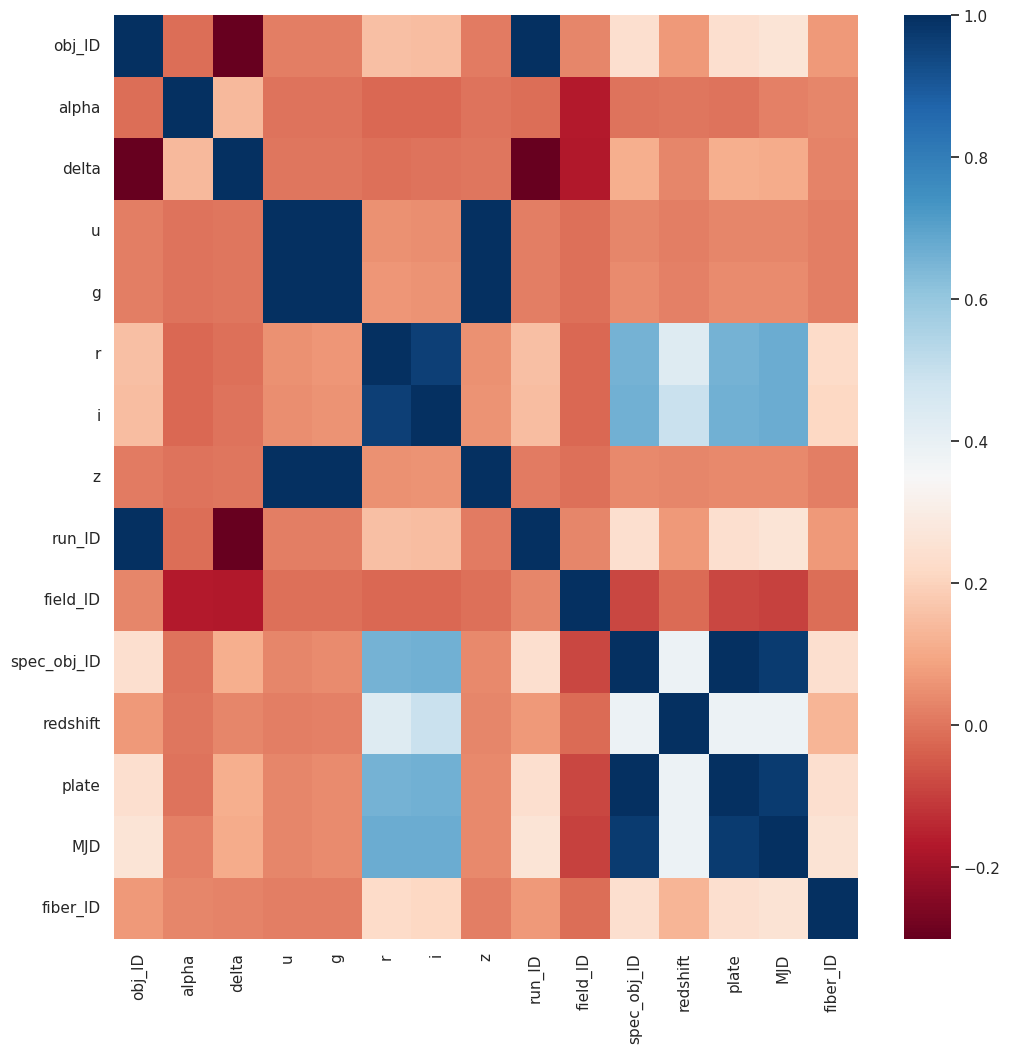

In [87]:
# Korelasyonların gösterilmesi
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu"
plt.show()


In [7]:


def iliski_analizi_yap(df, sutunlar, hedef_sutun='class'):
    """
    Belirtilen sütunların hedef sınıflara göre dağılımını görselleştirir.
    """
    n = len(sutunlar)
    plt.figure(figsize=(15, 5 * n))
    
    for i, sutun in enumerate(sutunlar):
        plt.subplot(n, 1, i + 1)
        # Boxplot ile dağılımı gör
        sns.boxplot(x=hedef_sutun, y=sutun, data=df, palette='viridis')
        plt.title(f'{sutun} vs {hedef_sutun} İlişkisi')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Kullanımı:
# incelemek_istedigin_list = ['redshift', 'MJD', 'plate', 'u']
# iliski_analizi_yap(df, incelemek_istedigin_list)

Astronomide sadece u veya sadece g değerine bakmak yerine, genellikle ikisinin farkına ($u - g$) bakılır. Buna "Renk İndeksi" denir.Bu fark, bir yıldızın veya galaksinin ne kadar "mavi" veya "kırmızı" olduğunu söyler.

Random Forest veya Gradient Boosting modelleri), bu tür "doğrusal bağımlı" fiziksel özellikleri kullanarak daha hassas karar sınırları çizebilir.

Neden? Bir yıldız ile bir kuasarın r değeri aynı olabilir, ancak i değerindeki çok küçük bir fark, onları birbirinden ayırabilir.

/tmp/ipykernel_55/82739927.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=hedef_sutun, y=sutun, data=df, palette='viridis')
/tmp/ipykernel_55/82739927.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=hedef_sutun, y=sutun, data=df, palette='viridis')


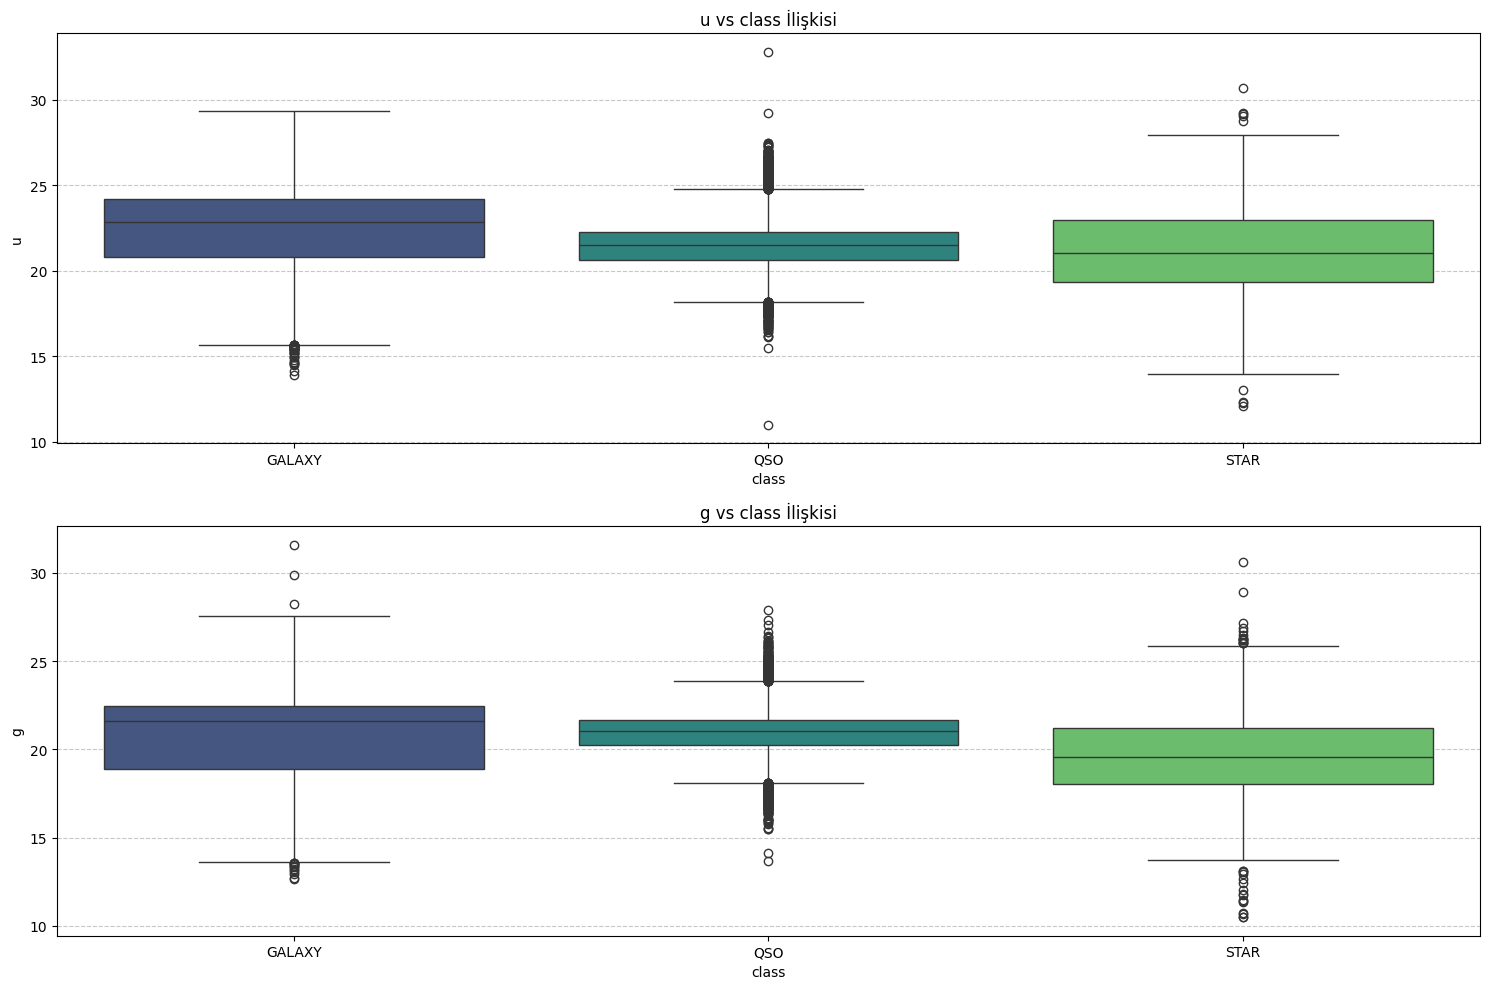

In [8]:
# Sadece mantıklı değerleri tut (Örn: u ve g'nin -1000'den büyük olduğu satırlar)
df_clean = df[(df['u'] > -1000) & (df['g'] > -1000)]

# Şimdi tekrar görselleştir
iliski_analizi_yap(df_clean, ['u', 'g']) #burada korelsyonları yüksek iki değişkenin hedef değişken üzerinden ilişkisini inceledim 

/tmp/ipykernel_55/82739927.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=hedef_sutun, y=sutun, data=df, palette='viridis')
/tmp/ipykernel_55/82739927.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=hedef_sutun, y=sutun, data=df, palette='viridis')


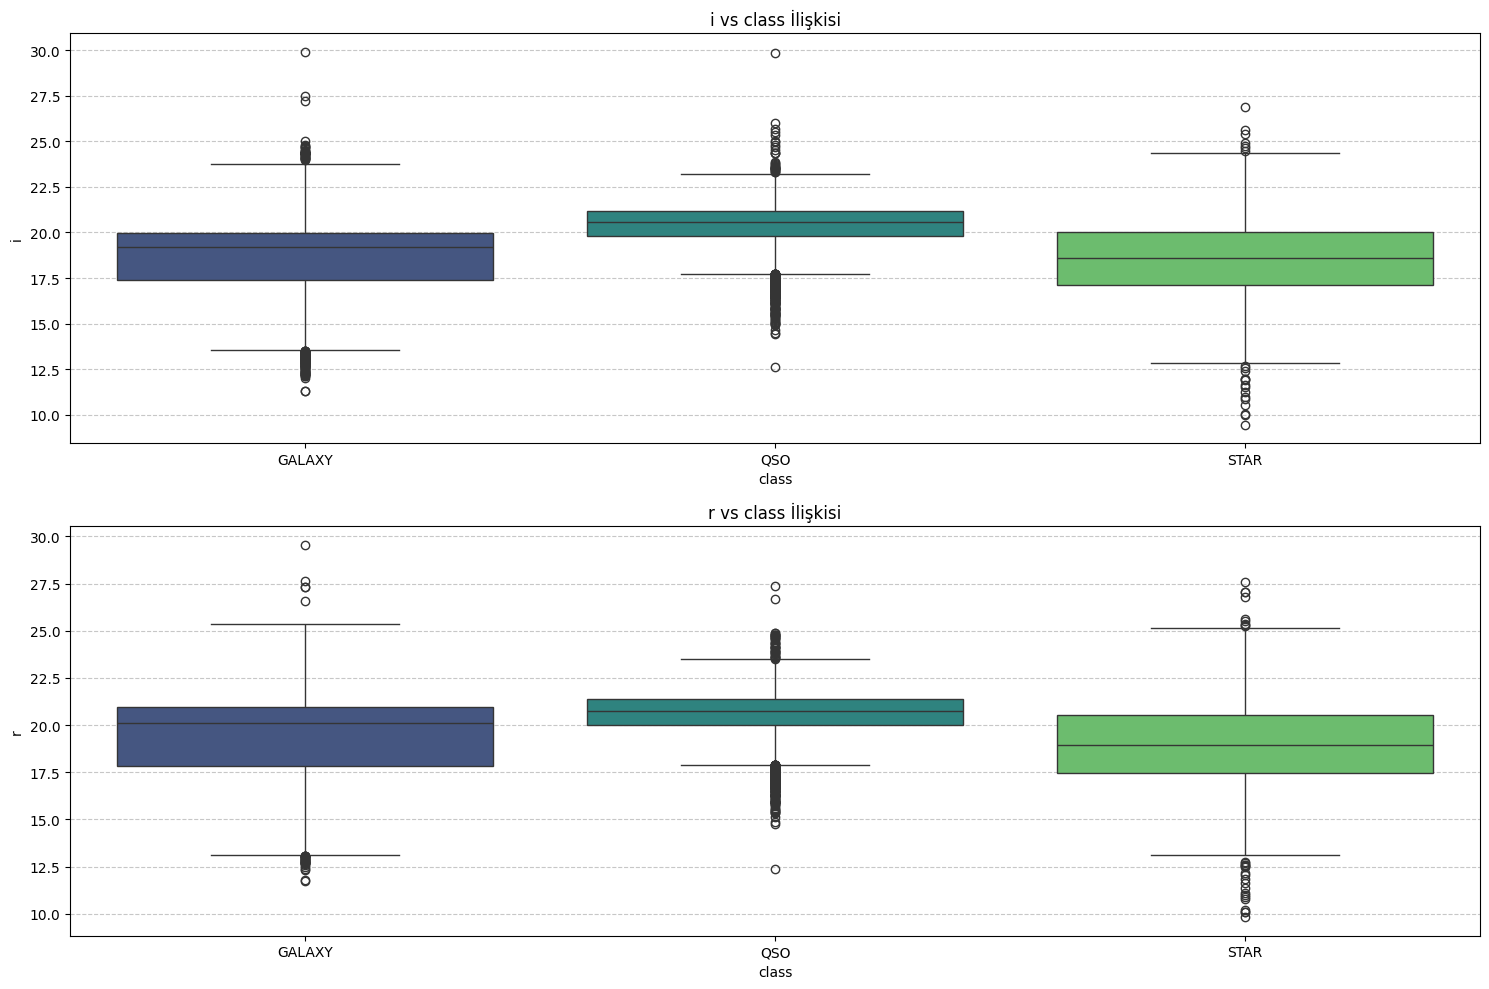

In [11]:
# Hatalı -9999 değerlerini ve uç değerleri temizleyelim
df_filtered = df[
    (df['u'] > 0) & (df['u'] < 30) & 
    (df['g'] > 0) & (df['g'] < 30) &
    (df['r'] > 0) & (df['r'] < 30) &
    (df['i'] > 0) & (df['i'] < 30) &
    (df['z'] > 0) & (df['z'] < 30) &
    (df['redshift'] > -0.1) & (df['redshift'] < 5)
].copy()
# Şimdi box plot çizdir
iliski_analizi_yap(df_filtered, ['i','r'])

#### ÖZELLİK MÜHENDİSLİĞİ VE VERİ ÖN HAZIRLIĞI

Bu farklar gök cisminin "sıcaklığını" ve "kimyasal bileşimini" temsil eder. Örneğin, bir yıldızın maviye mi yoksa kırmızıya mı daha yakın olduğunu bize gösterir

"redshift" evrenin genişlemesiyle ilgili fiziksel bir bilgidir ve cismin bizden uzaklığını/hızını söyler.

In [19]:
def apply_feature_engineering(df):

    # Filtre değerleri genellikle 0-30 arasındadır, hatalı -9999 değerlerini eliyoruz
    filtreler = ['u', 'g', 'r', 'i', 'z']
    for f in filtreler:
        df = df[(df[f] > 0) & (df[f] < 40)]
    
    # Redshift için makul bir sınır (Yıldızlar için hafif negatif olabilir)
    df = df[df['redshift'] > -0.1].copy()

    # 2. Renk İndeksleri Oluşturma (Fiziksel Çıkarım: Renk = Fark)
    # Bu işlem, spektrumun eğimini modele öğretir
    df['u-g'] = df['u'] - df['g']
    df['g-r'] = df['g'] - df['r']
    df['r-i'] = df['r'] - df['i']
    df['i-z'] = df['i'] - df['z']

    # 3. Gereksiz ve Teknik Sütunları Silme
    # MJD, plate ve spec_obj_ID arasındaki %97+ korelasyon nedeniyle bilgi tekrarını önlüyoruz
    # Ayrıca obj_ID gibi teknik kimlikleri çıkarıyoruz
    silinecek_sutunlar = [
        'obj_ID', 'run_ID', 'rerun_ID', 'field_ID', 
        'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'
    ]
    df = df.drop(columns=silinecek_sutunlar)

    return df

# Uygulama:
df_final = apply_feature_engineering(df)

# Yeni korelasyonu kontrol et
print(df_final[['u-g', 'g-r', 'r-i', 'redshift']].corr())

               u-g       g-r       r-i  redshift
u-g       1.000000  0.283985  0.175064 -0.232527
g-r       0.283985  1.000000  0.519007 -0.209359
r-i       0.175064  0.519007  1.000000 -0.123634
redshift -0.232527 -0.209359 -0.123634  1.000000


In [21]:
new_cat_cols, new_cat_but_car, new_num_cols = grab_col_names(df_final)

Observations: 99999
Variables: 14
cat_cols: 2
num_cols: 12
cat_but_car: 0
num_but_cat: 1


In [23]:
df_final.head()

,alpha,delta,u,g,r,i,z,cam_col,class,redshift,u-g,g-r,r-i,i-z
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,GALAXY,0.634794,1.60352,1.88029,1.22928,0.37202
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,GALAXY,0.779136,1.94571,0.24744,1.41632,-0.44615
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,GALAXY,0.644195,2.59918,2.05413,1.26119,0.40030
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,GALAXY,0.932346,-1.63974,2.16494,1.10708,1.25444
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,GALAXY,0.116123,1.85690,1.08281,0.52036,0.43250


### AYKIRI DEĞERLER

In [20]:
##3.AYKIRI DEĞER ANALİZİ
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [27]:
for col in new_num_cols:
    if col != "class":
      print(col, check_outlier(df_final, col))

alpha False
delta False
u False
g True
r True
i True
z True
redshift True
u-g True
g-r True
r-i True
i-z True


In [28]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in new_num_cols:
    if col != "class":
        replace_with_thresholds(df_final,col)

In [29]:
for col in new_num_cols:
    if col != "class":
      print(col, check_outlier(df_final, col))

alpha False
delta False
u False
g False
r False
i False
z False
redshift False
u-g False
g-r False
r-i False
i-z False


In [30]:
new_cat_cols

['class', 'cam_col']

In [34]:
df_final['cam_col'].dtype

dtype('int64')

### MODEL

In [41]:
X = df_final.drop('class', axis=1) # 'class' dışındaki her şey özellik
y = df_final['class']

In [42]:
from sklearn.model_selection import train_test_split

# Veriyi ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,     
    random_state=42,     # Her çalıştırdığında aynı ayrımı yapması için (tutarlılık)
    stratify=y           # Sınıf dağılımını (oranlarını) hem train hem testte koru
)

In [43]:
print(f"Toplam veri sayısı: {len(X)}")
print(f"Eğitim seti sayısı: {len(X_train)}")
print(f"Test seti sayısı: {len(X_test)}")

# Sınıf oranlarını kontrol et
print("\nEğitim setindeki sınıf dağılımı:")
print(y_train.value_counts(normalize=True))

Toplam veri sayısı: 99999
Eğitim seti sayısı: 74999
Test seti sayısı: 25000

Eğitim setindeki sınıf dağılımı:
class
GALAXY    0.594448
STAR      0.215936
QSO       0.189616
Name: proportion, dtype: float64


### MODELİMİZİ DEĞERLENDİRELİM VE HANGİ MODEL BAZINDA HANGİ FEATURE DAHA ÖNEMLİ

#### Random Forest

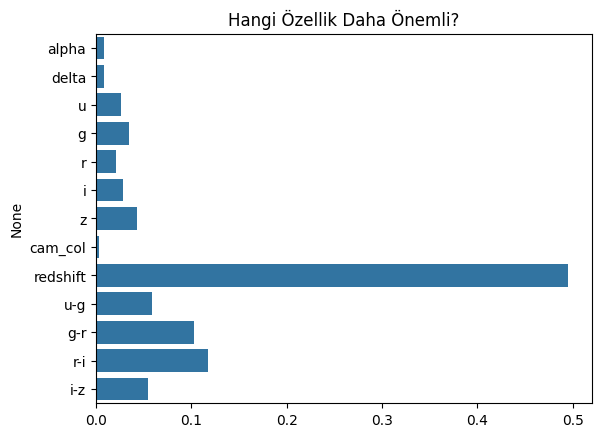

In [47]:
# Random Forest modelini eğitme
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Özellik önem düzeylerini görselleştirme
importances = rf_model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Hangi Özellik Daha Önemli?")
plt.show()

#### Desicion Tree

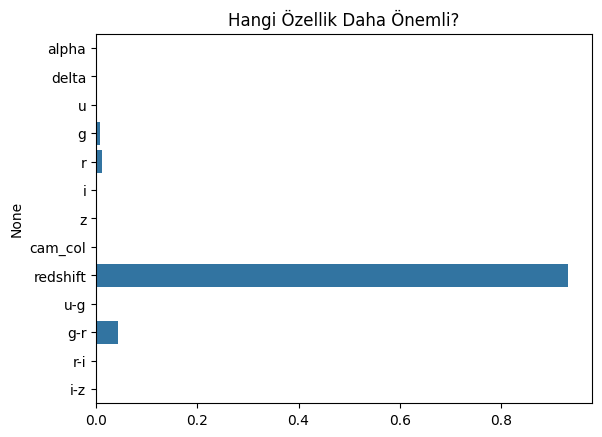

In [45]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Özellik önem düzeylerini görselleştirme
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Hangi Özellik Daha Önemli?")
plt.show()

### Random Forest Report

<Figure size 800x600 with 0 Axes>

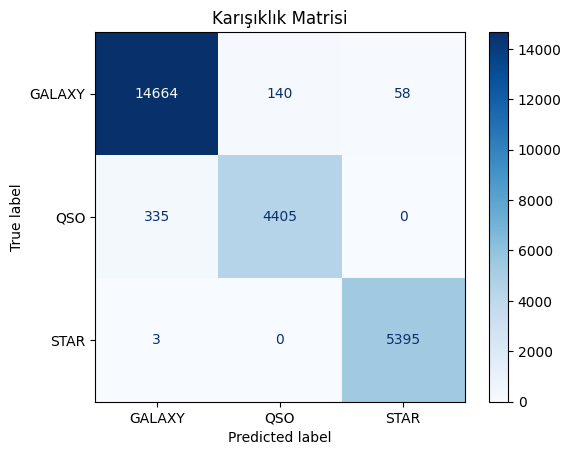

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tahminleri al
y_pred = rf_model.predict(X_test)

# Matrisi oluştur ve görselleştir
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Karışıklık Matrisi")
plt.show()

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     14862
         QSO       0.97      0.93      0.95      4740
        STAR       0.99      1.00      0.99      5398

    accuracy                           0.98     25000
   macro avg       0.98      0.97      0.98     25000
weighted avg       0.98      0.98      0.98     25000



### Desicion Tree Report

<Figure size 800x600 with 0 Axes>

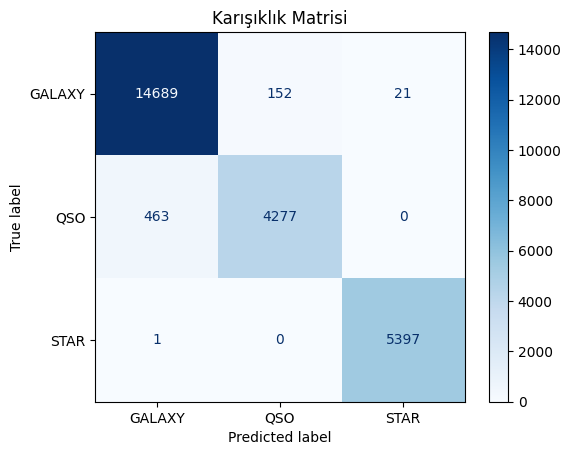

In [50]:
y_pred = model.predict(X_test)

# Matrisi oluştur ve görselleştir
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Karışıklık Matrisi")
plt.show()

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     14862
         QSO       0.97      0.90      0.93      4740
        STAR       1.00      1.00      1.00      5398

    accuracy                           0.97     25000
   macro avg       0.98      0.96      0.97     25000
weighted avg       0.97      0.97      0.97     25000

